In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
'''退化模型'''
def modeling_degrade(img, k=0.0025):
    """
    img: 输入图像(傅里叶频谱)
    k: 与湍流性质有关的常数,默认0.0025剧烈湍流
    """
    N, M = img.shape[:2]
    
    u = np.arange(M)
    v = np.arange(N)
    
    u, v = np.meshgrid(u, v)
    
    temp = (u - M//2)**2 + (v - N//2)**2
    
    kernel = np.exp(-k * np.power(temp, 5/6))
    
    return kernel

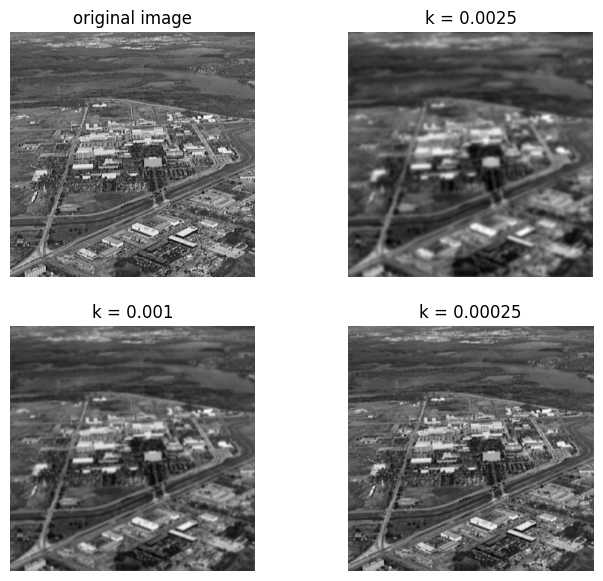

In [3]:
'''用建模法估计退化函数'''
def get_degenerate_image(img,img_deg):
    '''img:输入图像
    img_deg:退化函数'''
    fft = np.fft.fft2(img)
    fft = np.fft.fftshift(fft) #中心化

    fft2 = fft*img_deg   #FFT*H(u,v)
    fft2 = np.fft.ifftshift(fft2)  #去中心化
    ifft = np.fft.ifft2(fft2)  #逆变换
    result = np.abs(ifft)
    return result  #返回退化后的图像

img_ori = cv2.imread(r"C:\Users\23282\Desktop\PyL\DIP\imageset\aerial_view.tif",0)
fft1 = np.fft.fft2(img_ori)

deg0025 = modeling_degrade(fft1,k=0.0025)  #k=0.0025
deg001 = modeling_degrade(fft1,k=0.001)  # k=0.001
deg00025 = modeling_degrade(fft1,k=0.00025)  #k=0.00025

img1 = get_degenerate_image(img_ori,deg0025)
img2 = get_degenerate_image(img_ori,deg001)
img3 = get_degenerate_image(img_ori,deg00025)

plt.figure(figsize=(8,7))
plt.subplot(221),plt.title('original image'),plt.imshow(img_ori,'gray'),plt.axis('off')
plt.subplot(222),plt.title('k = 0.0025'),plt.imshow(img1,'gray'),plt.axis('off')
plt.subplot(223),plt.title('k = 0.001'),plt.imshow(img2,'gray'),plt.axis('off')
plt.subplot(224),plt.title('k = 0.00025'),plt.imshow(img3,'gray'),plt.axis('off')
plt.show()

In [4]:
'''运动模糊函数'''
def motion_blur(img,degree = 12,angle = 45):
    '''运动模糊函数
    img:输入图像
    degree:模糊程度
    angle:运动角度
    '''
    image = np.array(img)
    # 这里生成任意角度的运动模糊kernel的矩阵， degree越大，模糊程度越高
    M = cv2.getRotationMatrix2D((degree/2,degree/2),angle,1)
    '''cv2.getRotationMatrix2D()参数含义
    #旋转中心
    #旋转角度
    #旋转后的缩放比例'''
    motion_blur_kernel = np.diag(np.ones(degree))
    motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, M, (degree, degree))
    '''
    cv2.warpAffine() 仿射变换
    scr：变换操作的输入图像
    M：仿射变换矩阵，2行3列
    dsize： 输出图像的大小，二元元组 (width, height)
    dst：变换操作的输出图像，可选项
    flags：插值方法，整型（int），可选项
    '''
    motion_blur_kernel = motion_blur_kernel / degree
    blurred = cv2.filter2D(image, -1, motion_blur_kernel)
    '''卷积函数cv2.filter2D（src,ddepth,kernel,anchor,delta,borderType）
    src 是需要处理的图像，即原始图像
    ddepth是处理结果图像的图像深度，一般使用-1表示与原始图像使用相同的图像深度
    kernel是卷积核，是一个单通道的数组。
    anchor 是锚点，其默认值是（-1,-1），表示当前计算均值的点位于核的中心点位 置
    delta 是修正值，它是可选项。如果该值存在，会在基础滤波的结果上加上该值作 为最终的滤波处理结果。
    borderType是边界样式，该值决定了以何种情况处理边界，通常使用默认值即可
    '''

    # convert to uint8
    cv2.normalize(blurred, blurred, 0, 255, cv2.NORM_MINMAX)
    blurred = np.array(blurred, dtype=np.uint8)
    return blurred


In [5]:
'''点扩散函数'''
def get_motion_dsf(image,angle,distance):
    '''点扩散函数
    image:输入图像
    angle:模糊的角度
    distance:运动像素个数
    '''
    PSF = np.zeros(image.shape)
    x_center = (image.shape[0] - 1) / 2
    y_center = (image.shape[1] - 1) / 2
    sin_val = math.sin(angle * math.pi / 180)
    cos_val = math.cos(angle * math.pi / 180)
    # 将对应角度上distance个点置成1
    for i in range(distance):
        x_offset = round(sin_val * i)
        y_offset = round(cos_val * i)
        PSF[int(x_center - x_offset), int(y_center + y_offset)] = 1
    return PSF / PSF.sum()

(<Axes: title={'center': 'Motion Blur'}>,
 Text(0.5, 1.0, 'Motion Blur'),
 (-0.5, 687.5, 687.5, -0.5))

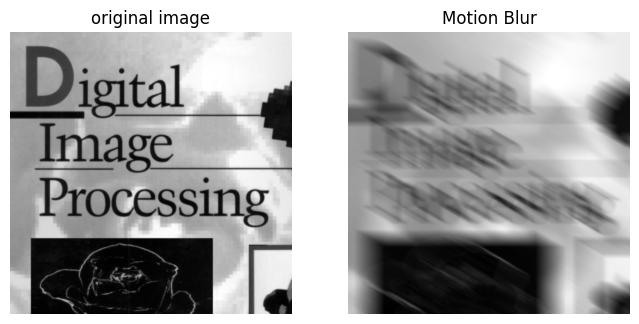

In [6]:
book = cv2.imread(r"C:\Users\23282\Desktop\PyL\DIP\imageset\book-cover.tif",0)
#封面图象

book_blur = motion_blur(book,75,15)

plt.figure(figsize=(8,6))
plt.subplot(121),plt.title('original image'),plt.imshow(book,'gray'),plt.axis('off')
plt.subplot(122),plt.title('Motion Blur'),plt.imshow(book_blur,'gray'),plt.axis('off')

In [7]:
'''巴特沃斯低通滤波器'''
def butterworth_low_pass_filter(FS,radius=5,n=1):
    '''
    FS为图像的傅里叶变换频谱
    radius为滤波器半径,默认为5
    n为阶数,默认为1
    '''
    M , N = FS.shape[0],FS.shape[1]   #M行N列
    center = (M//2,N//2)   #滤波器中心为频谱图象中心
    u = np.arange(N)
    v = np.arange(M)
    u, v = np.meshgrid(u, v)

    D = np.sqrt((u - center[1])**2 + (v - center[0])**2)
    blpf = 1/(1+((D/radius)**(2*n)))

    return blpf

#得到图像中心化的傅里叶频谱
def centralized_2d(img):
    fft = np.fft.fft2(img)
    fftshift = np.fft.fftshift(fft)
    return fftshift

#对中心化的傅里叶频谱逆变换
def IFFT(fftshift):
    fft = np.fft.ifftshift(fftshift)
    img = np.fft.ifft2(fft)
    img = np.abs(img)
    return img

#归一化
def normalize(array):
    '''对array作归一化处理'''
    return (array - array.min())/(array.max() - array.min())

In [8]:
'''逆滤波'''
#F[bar](u,v)=G(u,v)/H(u,v)
#F[bar](u,v)=F(u,v)+N(u,v)/H(u,v)

fxy = cv2.imread(r"C:\Users\23282\Desktop\PyL\DIP\imageset\aerial_view.tif",0)

#利用退化函数退化图像
Huv = modeling_degrade(img_ori,k = 0.004)
gxy = get_degenerate_image(img_ori,Huv)

#逆滤波
Guv = centralized_2d(gxy)
Fbar = Guv/Huv
fxybar = IFFT(Fbar)

#半径40之外截止
blpf_40 = butterworth_low_pass_filter(Huv,radius=40,n=10)

Fbar40 = Guv/Huv * blpf_40
fxy_40 = IFFT(Fbar40)

#半径70之外截止
blpf_200 = butterworth_low_pass_filter(Huv,radius=70,n=10)

Fbar200 = Guv/Huv * blpf_200
fxy_200 = IFFT(Fbar200)

#半径100之外截止
blpf_85 = butterworth_low_pass_filter(Huv,radius=100,n=10)

Fbar85 = Guv/Huv * blpf_85
fxy_85 = IFFT(Fbar85)


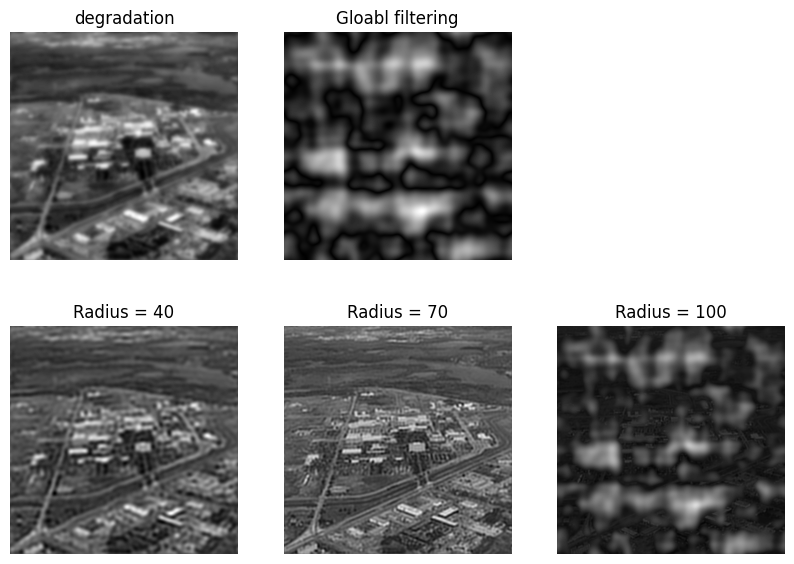

In [9]:
plt.figure(figsize=(10,7))
plt.subplot(231),plt.title('degradation'),plt.imshow(gxy,'gray'),plt.axis('off')
plt.subplot(232),plt.title('Gloabl filtering'),plt.axis('off'),plt.imshow(fxybar,'gray')
plt.subplot(234),plt.title('Radius = 40'),plt.axis('off'),plt.imshow(fxy_40,'gray')
plt.subplot(235),plt.title('Radius = 70'),plt.axis('off'),plt.imshow(fxy_200,'gray')
plt.subplot(236),plt.title('Radius = 100'),plt.axis('off'),plt.imshow(fxy_85,'gray')
plt.show()

In [10]:
#给图像添加高斯噪声
def add_guassian_noise(img, mean = 0, sigma = 0.1):
    '''给图像添加高斯噪声
    img:输入图像
    mean:噪声均值
    sigma:噪声标准差
    '''
    imag = np.array(img,dtype= float)
    noise = np.random.normal(mean,sigma,imag.shape)
    imag_out = imag + noise
    imag_out = np.uint8(normalize(imag_out)*255)

    return imag_out

In [11]:
'''点扩散函数'''
def get_motion_dsf(image,angle,distance):
    '''点扩散函数
    image:输入图像
    angle:模糊的角度
    distance:运动像素个数
    '''
    PSF = np.zeros(image.shape)
    x_center = (image.shape[0] - 1) / 2
    y_center = (image.shape[1] - 1) / 2
    sin_val = math.sin(angle * math.pi / 180)
    cos_val = math.cos(angle * math.pi / 180)
    # 将对应角度上distance个点置成1
    for i in range(distance):
        x_offset = round(sin_val * i)
        y_offset = round(cos_val * i)
        PSF[int(x_center - x_offset), int(y_center + y_offset)] = 1
    return PSF / PSF.sum()

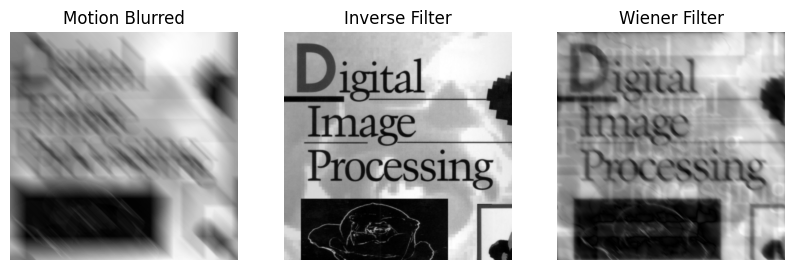

In [12]:
'''维纳滤波'''
def wiener_filter(input, PSF,eps ,k=0.01):
    '''维纳滤波
    input:输入图像
    PSF:退化函数
    eps:平均噪声功率
    K:默认为0.01
    '''
    input_fft = np.fft.fft2(input)
    PSF_fft = np.fft.fft2(PSF) + eps  
    PSF_fft_1 = np.conj(PSF_fft) / (np.abs(PSF_fft)**2 + k)  #np.conj()获取共轭复数
    result = np.fft.ifft2(input_fft * PSF_fft_1)
    result = np.abs(np.fft.fftshift(result))
    return result
 
'''逆滤波'''
def inverse_filter(input, PSF, eps = 1e-8): 
    """
    逆滤波
    input: input image
    PSF: known PSF
    eps: epsilon
    """
    input_fft = np.fft.fft2(input)
    PSF_fft = np.fft.fft2(PSF) + eps           #噪声功率，这是已知的
    result = np.fft.ifft2(input_fft / PSF_fft) #计算F(u,v)的傅里叶反变换
    result = np.abs(np.fft.fftshift(result))
    return result


#对原图像进行运动模糊
image = book = cv2.imread(r"C:\Users\23282\Desktop\PyL\DIP\imageset\book-cover.tif",0)
PSF = get_motion_dsf(image, 135, 100)
PSFfft = centralized_2d(PSF)
imgFFT = centralized_2d(image)
pic = PSFfft * imgFFT
pic = np.fft.ifft2(pic)
pic = np.fft.ifftshift(pic)
pic = np.abs(pic)

#对模糊图像进行逆滤波
result1 = inverse_filter(pic,PSF,1e-8)

#对模糊图像进行维纳滤波
result2 = wiener_filter(pic,PSF,1e-8,0.01)

plt.figure(figsize=(10,5))
plt.subplot(131),plt.title('Motion Blurred'),plt.imshow(pic,'gray'),plt.axis('off')
plt.subplot(132),plt.title('Inverse Filter'),plt.imshow(result1,'gray'),plt.axis('off')
plt.subplot(133),plt.title('Wiener Filter'),plt.imshow(result2,'gray'),plt.axis('off')
plt.show()


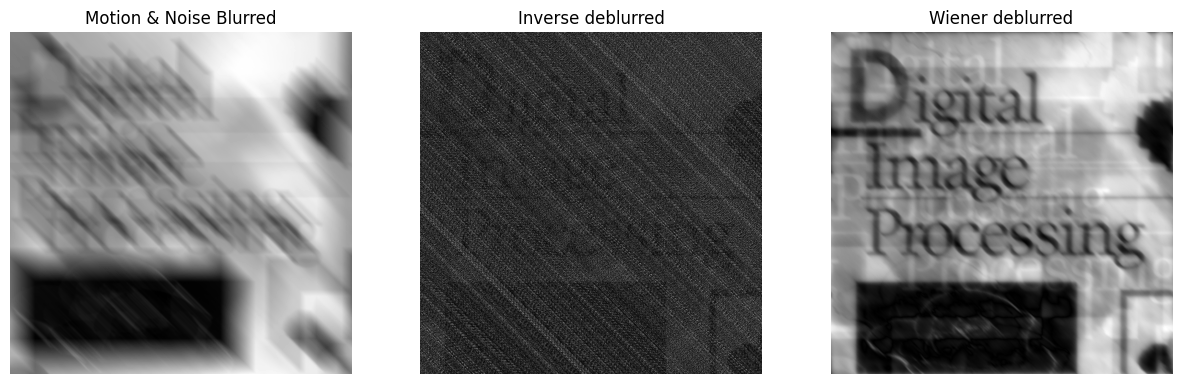

In [13]:
#给模糊图像增加高斯噪声
pic1 = add_guassian_noise(pic,mean = 0, sigma = 0.1)
#对模糊图像进行逆滤波
result1 = inverse_filter(pic1,PSF,1e-8)

#对模糊图像进行维纳滤波
result2 = wiener_filter(pic1,PSF,1e-8,0.01)

plt.figure(figsize=(15,10))
plt.subplot(131),plt.title('Motion & Noise Blurred'),plt.imshow(pic1,'gray'),plt.axis('off')
plt.subplot(132),plt.title('Inverse deblurred'),plt.imshow(result1,'gray'),plt.axis('off')
plt.subplot(133),plt.title('Wiener deblurred'),plt.imshow(result2,'gray'),plt.axis('off')
plt.show()

In [14]:
'''约束最小二乘方滤波'''
def laplac_kernel_fft(image):
    '''得到拉普拉斯核的傅里叶变换'''
    h, w = image.shape[:2]
    h_pad, w_pad = h - 3, w - 3
    p_xy = np.array([[0, -1, 0],
                 [-1, 4, -1],
                 [0, -1, 0]])
    p_pad = np.pad(p_xy, ((h_pad//2, h_pad - h_pad//2), (w_pad//2, w_pad - w_pad//2)), mode='constant')
    p_uv = np.fft.fft2(p_pad)
    return p_uv

def least_square_filter(image,PSF,eps,gamma = 0.01):
    '''最小二乘方滤波
    image:输入退化图像
    PSF:退化函数
    eps:平均噪声功率
    gamma:默认为0.01'''
    Guv = np.fft.fft2(image)
    PSF_fft = np.fft.fft2(PSF)
    conj = PSF_fft.conj()   #共轭复数
    Puv = laplac_kernel_fft(image)
    abs_conj = np.abs(PSF_fft)**2
    huv = conj/(abs_conj + gamma*(np.abs(Puv)**2))
    result = np.fft.ifft2(huv * Guv)
    result = np.abs(np.fft.fftshift(result))

    return result

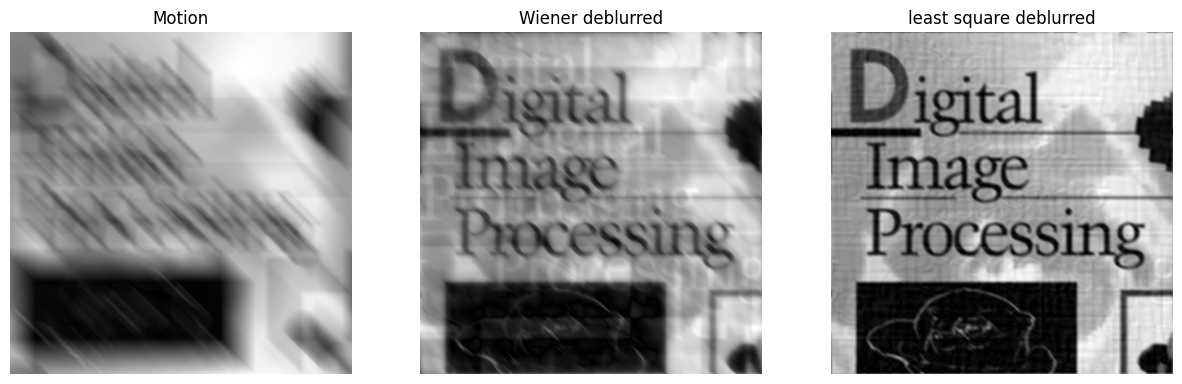

In [15]:
#对模糊图像进行约束最小二乘方滤波和维纳滤波
result1 = least_square_filter(pic,PSF,1e-8,gamma=0.01)
result2 = wiener_filter(pic,PSF,1e-8,0.01)
plt.figure(figsize=(15,10))
plt.subplot(131),plt.title('Motion'),plt.imshow(pic,'gray'),plt.axis('off')
plt.subplot(132),plt.title('Wiener deblurred'),plt.imshow(result2,'gray'),plt.axis('off')
plt.subplot(133),plt.title('least square deblurred'),plt.imshow(result1,'gray'),plt.axis('off')
plt.show()

In [16]:
'''由投影重建图像'''
#模拟一个图形
img = np.zeros((256,256))
img[107:148] = 1.0
img[105:107] = 0.95
img[103:105] = 0.75
img[101:103] = 0.55
img[99:101] = 0.35
img[97:99] = 0.25
img[148:150] = 0.95
img[150:152] = 0.75
img[152:154] = 0.55
img[154:156] = 0.35
img[156:158] = 0.25

In [17]:
total_img = img.copy()
total_img2 = img.copy()
#旋转并叠加
for i in range(32):    #32个旋转反投影重建
    angle = (360/32) / 2 * (i+1)
    C1 = cv2.getRotationMatrix2D((img.shape[1]/2.0,img.shape[0]/2.0),angle ,1)
    new_img = cv2.warpAffine(img,C1,(img.shape),borderValue= 0 )
    total_img = total_img + new_img

for i in range(64):    #64个旋转反投影重建
    angle = (360/64) / 2 * (i+1)
    C1 = cv2.getRotationMatrix2D((img.shape[1]/2.0,img.shape[0]/2.0),angle ,1)
    new_img = cv2.warpAffine(img,C1,(img.shape),borderValue= 0 )
    total_img2 = total_img2 + new_img

total_img = normalize(total_img)
total_img2 = normalize(total_img2)

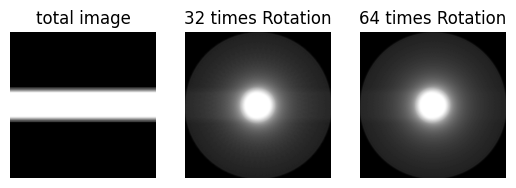

In [18]:
plt.figure()
plt.subplot(131),plt.imshow(img,'gray'),plt.title('total image'),plt.axis('off')
plt.subplot(132),plt.imshow(total_img,'gray'),plt.title('32 times Rotation'),plt.axis('off')
plt.subplot(133),plt.imshow(total_img2,'gray'),plt.title('64 times Rotation'),plt.axis('off')
plt.show()

In [24]:
'''雷登变换'''
from scipy import ndimage
def Radon_Transform(img,step):
    '''雷登变换
    img:输入图像
    step:雷登变换的步长，与图像高度相同'''
    channels = img.shape[0]
    dst = np.zeros((channels,channels),dtype = np.float32)

    for i in range(step):
        res = ndimage.rotate(img,-i*180 / step ,reshape=False).astype(np.float32)

        dst[:,i] = sum(res)
    # dst = ndimage.rotate(dst, 270, reshape=False) # 旋转后就跟书上的结果一致
    return dst

'''雷登反变换'''
def Inverse_Radon_Transform(image, steps):
    '''雷登反变换
    img:输入图像
    step:雷登变换的步长，与图像高度相同'''
    channels = len(image[0])
    dst = np.zeros((steps, channels, channels))
    for i in range(steps):
        # 传入的图像中的每一列都对应于一个角度的投影值
        # 这里用的图像是上篇博文里得到的Radon变换后的图像裁剪后得到的
        temp = image[:, i]
        # 这里利用维度扩展和重复投影值数组来模拟反向均匀回抹过程
        temp_expand_dim = np.expand_dims(temp, axis=0)
        temp_repeat = temp_expand_dim.repeat(channels, axis=0)
        dst[i] = ndimage.rotate(temp_repeat, i*180 / steps, reshape=False).astype(np.float64)
    # 各个投影角度的投影值已经都保存在origin数组中，只需要将它们相加即可    
    iradon = np.sum(dst, axis=0)
    
    return iradon

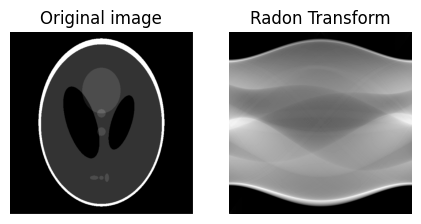

In [25]:
img = cv2.imread(r"C:\Users\23282\Desktop\PyL\DIP\imageset\shepp-logan-phantom.tif",0)

rt = Radon_Transform(img,img.shape[0])

plt.figure(figsize=(8,6))
plt.subplot(131),plt.imshow(img,'gray'),plt.title('Original image'),plt.axis('off')
plt.subplot(132),plt.imshow(rt,'gray'),plt.title('Radon Transform'),plt.axis('off')

plt.show()

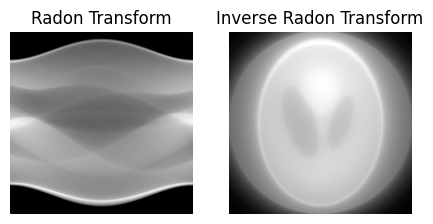

In [26]:
#雷登反变换
irt = Inverse_Radon_Transform(rt,rt.shape[0])

plt.figure(figsize=(8,6))
plt.subplot(131),plt.imshow(rt,'gray'),plt.title('Radon Transform'),plt.axis('off')
plt.subplot(132),plt.imshow(irt,'gray'),plt.title('Inverse Radon Transform'),plt.axis('off')

plt.show()

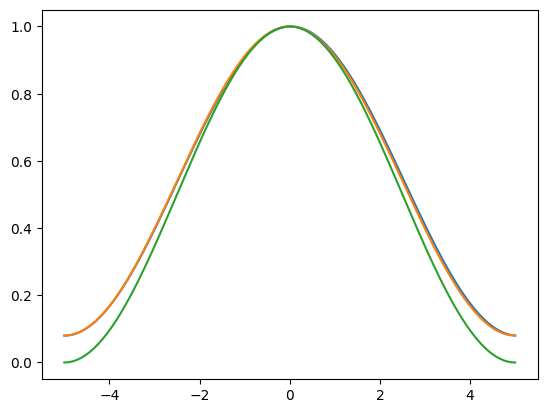

In [32]:
'''一维汉明窗'''
# 1维汉明窗
x = np.linspace(-5, 5, 200)

M = x.shape[0]

y = abs(x)

c = 0.54

hw = np.zeros_like(x)
for w in range(M):
    if 0 <= w <= M - 1:
        hw[w] = c + (c - 1) * np.cos(2 * np.pi * w / M)
    else:
        hw[w] = 0
        
np_hamming = np.hamming(M)
np_hann= np.hanning(M)

# plt.plot(x, y)
plt.plot(x, hw)
plt.plot(x, np_hamming)
plt.plot(x, np_hann)
plt.show()

In [35]:
'''滤波反投影重建'''
#反投影图像是按如下步骤得到的
#1、计算每个投影的一维傅里叶变换。
#2、将每个全里叶变换乘以滤波器传弟函数ω，这个传递函数已乘以一个合适的窗（如汉明窗）。
#3、得到的每个滤波后的变换的一维傅里叶反变换。
#4、对步骤3得到的所有一维反变换进行积分（求和）。
def box_filter(M, c):
    hw = np.zeros((M, ))
    for w in range(M):
        if 0 <= w <= M - 1:
            hw[w] = c + (c - 1) * np.cos(2 * np.pi * w / M)
        else:
            hw[w] = 0
    hw = np.fft.fft(hw)
    hw = np.fft.fftshift(hw)
    hw = np.real(hw)
#     hw = normalize(np.real(hw))
    return hw

'''R—L滤波器和S—L滤波器'''
def rl_filter(N, d):
    filterRL = np.zeros((N,))
    for i in range(N):
        filterRL[i] = - 1.0 / (np.power((i - N / 2) * np.pi * d, 2.0) + 1e-5) # 1e-5 加上一个不为零的小数，防止出现除0的问题
        if np.mod(i - N / 2, 2) == 0:
            filterRL[i] = 0
    filterRL[int(N/2)] = 1 / (4 * np.power(d, 2.0))
    return filterRL

def sl_filter(N, d):
    filterSL = np.zeros((N,))
    for i in range(N):
        filterSL[i] = - 2 / (np.pi**2.0 * d**2.0 * (4 * (i - N / 2)**2.0 - 1))
    return filterSL

def inverse_filter_radon_transform(image,step):
    #定义用与重建后的图像数组
    channels = len(image[0])
    origin = np.zeros((step,channels,channels))
    #选择滤波器传递函数
    # filter = box_filter(channels , 0.48)
    # filter = rl_filter(channels, 1)
    filter = sl_filter(channels, 1)
    for i in range(step):
        projectionValue = image[:, i]
        projectionValueFiltered = np.convolve(filter, projectionValue, "same")
        projectionValueExpandDim = np.expand_dims(projectionValueFiltered, axis=0)
        projectionValueRepeat = projectionValueExpandDim.repeat(channels, axis=0)
        origin[i] = ndimage.rotate(projectionValueRepeat, i*180/step, reshape=False).astype(np.float64)
    iradon = np.sum(origin, axis=0)
    
    return iradon

In [38]:

img= cv2.imread(r"C:\Users\23282\Desktop\PyL\DIP\imageset\shepp-logan-phantom.tif",0)
#进行雷登变换
img_radon = Radon_Transform(img,img.shape[0])
#雷登反变换
img_inverse_radon = Inverse_Radon_Transform(img_radon, img_radon.shape[0])
img_filter_inverse_radon = inverse_filter_radon_transform(img_radon, img_radon.shape[0])



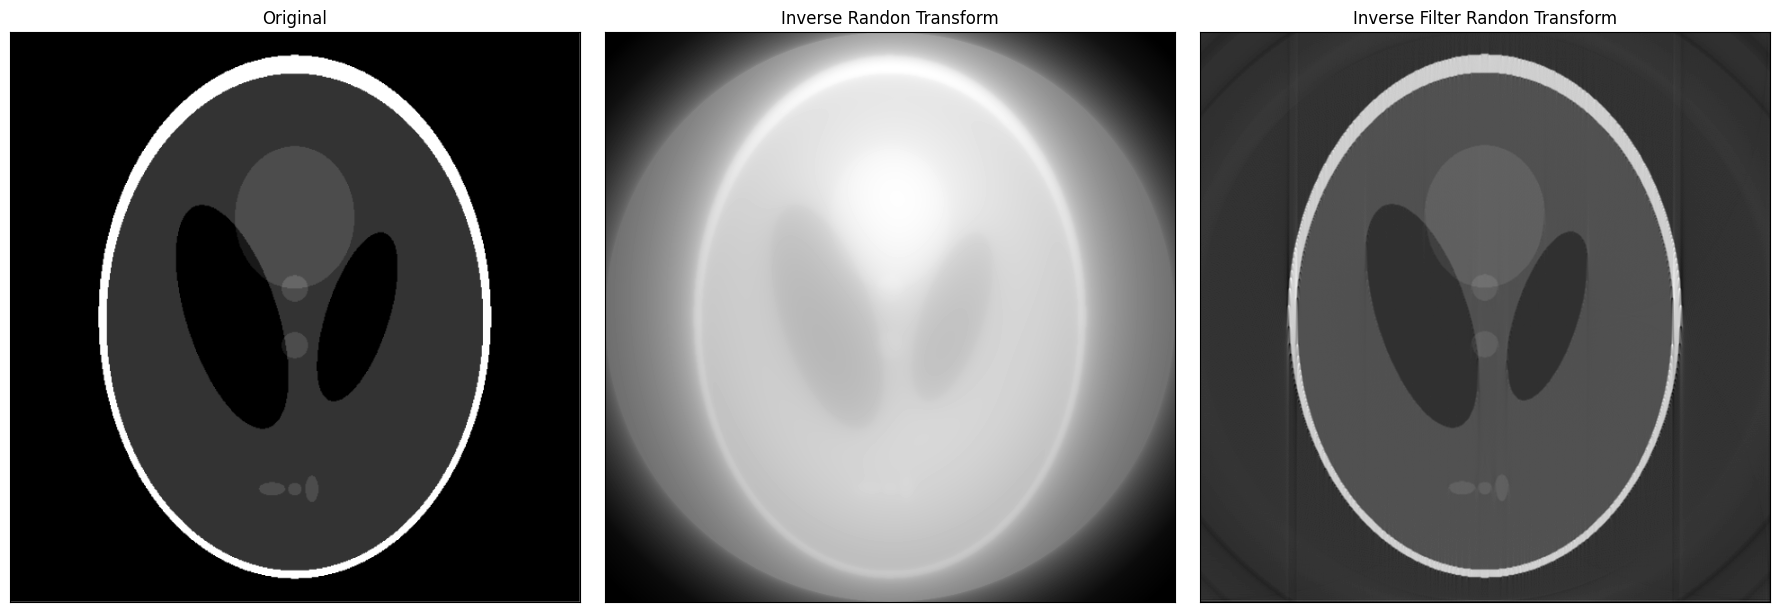

In [39]:
plt.figure(figsize=(18, 6))

plt.subplot(131), plt.imshow(img, 'gray'), plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(img_inverse_radon, 'gray'), plt.title('Inverse Randon Transform'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(img_filter_inverse_radon, 'gray'), plt.title('Inverse Filter Randon Transform')
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()
